In [1]:
#import potrebnych kniznic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint
from keras.callbacks import LambdaCallback

In [2]:
#nacitanie dat zo suboru do datasetu
data=pd.read_csv('diabetes.csv')
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
#zistime ci v datasete mame prazdny zaznam
data.isnull().values.any()

False

In [4]:
#pozrieme sa kde v zazname nam chybaju udaje cize 0
(data==0).sum()

Pregnancies                 111
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [5]:
#pregnancies a outcome nas nezaujima kedze tam sa moze nachadzat hodnota 0
#ale v ostatnych pripadoch ich potrebujeme nahradit priemerom

#funkcia ktora prejde datasetom a nahradi hodnoty s priemerom
def replace_zero(df, field, target):
    mean_by_target=df.loc[df[field]!=0, [field, target]].groupby(target).mean()
    data.loc[(df[field]==0)&(df[target]==0), field]=mean_by_target.iloc[0][0]
    data.loc[(df[field]==0)&(df[target]==1), field]=mean_by_target.iloc[1][0]

#zadame pre ktore stlpce chceme aplikovat funkciu replace_zero
for col in ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']:   
    replace_zero(data, col, 'Outcome') 

In [6]:
#skontrolujeme ci vsetky potrebne udaje sa nahradili
(data==0).sum()

Pregnancies                 111
Glucose                       0
BloodPressure                 0
SkinThickness                 0
Insulin                       0
BMI                           0
DiabetesPedigreeFunction      0
Age                           0
Outcome                     500
dtype: int64

In [7]:
data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,206.846154,33.6,0.627,50,1
1,1,85.0,66.0,29.0,130.287879,26.6,0.351,31,0
2,8,183.0,64.0,33.0,206.846154,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.000000,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101.0,76.0,48.0,180.000000,32.9,0.171,63,0
764,2,122.0,70.0,27.0,130.287879,36.8,0.340,27,0
765,5,121.0,72.0,23.0,112.000000,26.2,0.245,30,0
766,1,126.0,60.0,33.0,206.846154,30.1,0.349,47,1


In [8]:
#ulozenie vsetkych riadkov stlpcov od 0 az po 8
X=data.iloc[:,0:8].values
#ulozenie vsetkych riadkov slpca 8 "outcome"
y=data.iloc[:,8].values

In [9]:
X

array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
       [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
       [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
       ...,
       [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
       [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
       [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]])

In [10]:
y

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1,

In [11]:
#spocitame unique values v outcome co je 1 alebo 0
values=data['Outcome'].value_counts()
values
#0 znamena ze osoba ma cukrovku

0    500
1    268
Name: Outcome, dtype: int64

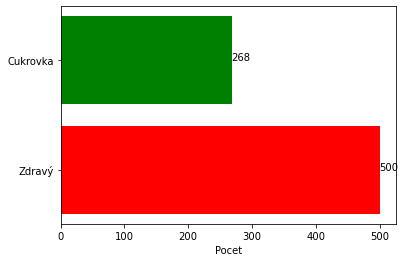

In [12]:
#vytvorenie grafu pre zobrazenie kolky maju cukrovku v datasete
labels=["Zdravý","Cukrovka"]
plt.barh(labels, values, color=['red', 'green'])
plt.xlabel('Pocet')
for index, value in enumerate(values):
    plt.text(value, index,
             str(value))
plt.show()

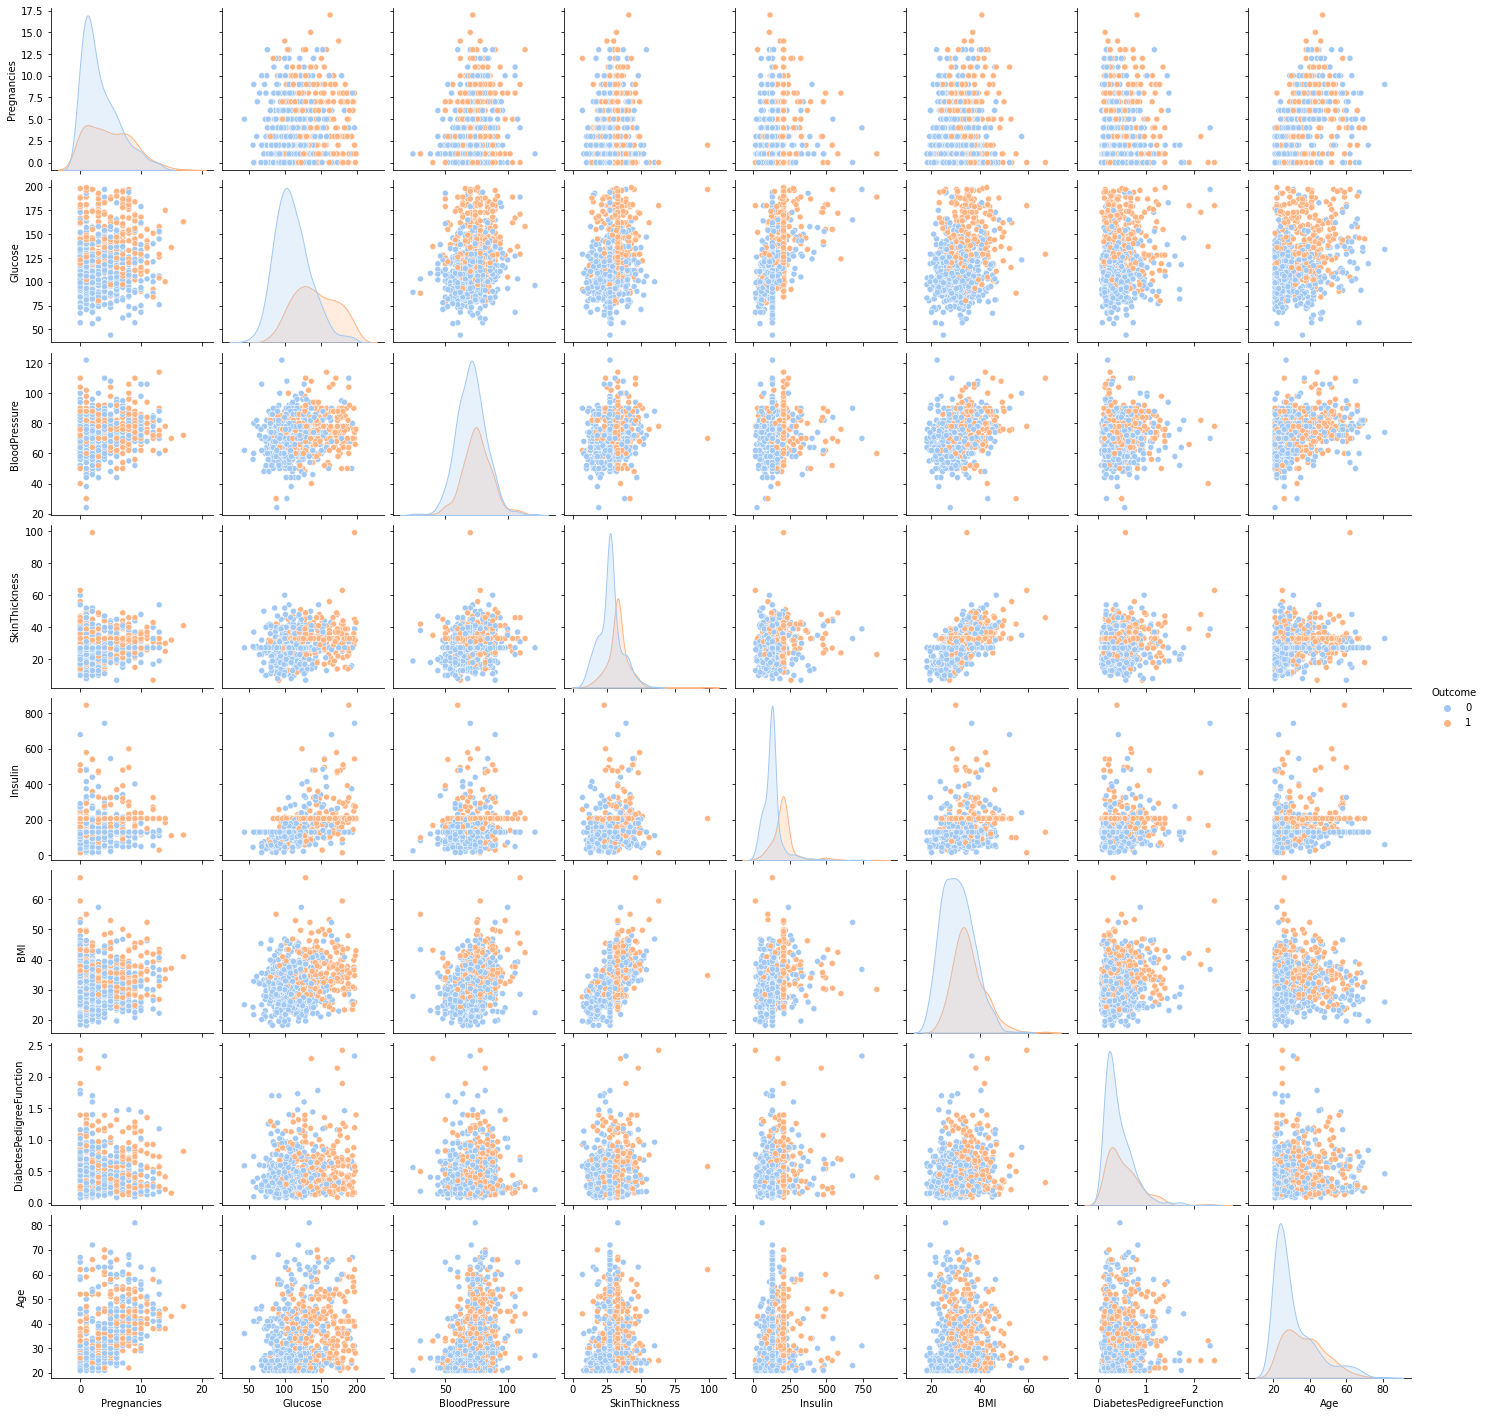

In [13]:
#vizualizacia dat v datasetu
sns.pairplot(data, hue="Outcome", palette="pastel")

In [14]:
#train_test_split-nahodne rozdielenie matic na train a test v pomere ktory nastavime
#test_size-nastavime pomer 0.25 je 25% cize 25% z datasetu bude testovaci
#random_state-ak sa nastavi tak sa bude generovat stale to iste rozdelenie
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.25, random_state=1)

In [15]:
#Standardizacia udajov pre X_train a X_test
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [16]:
X_train

array([[ 0.06459212, -0.8222356 , -0.97765754, ..., -0.57561455,
        -0.07502996, -0.94438203],
       [ 0.36223259, -0.35450564, -0.02859102, ..., -1.20715931,
        -0.18379061, -0.5204699 ],
       [-1.12596979,  1.95073486,  1.39500877, ...,  0.6434137 ,
        -0.46475564,  0.15778952],
       ...,
       [ 2.74335641,  0.1466336 ,  1.39500877, ...,  1.65682273,
         0.34792815,  0.7512665 ],
       [ 0.06459212,  1.65005132, -0.02859102, ...,  1.6861969 ,
         0.0337307 , -0.60525232],
       [ 1.5527945 , -0.65518919,  0.28776449, ...,  0.11467856,
         0.59566076,  1.09039621]])

In [17]:
X_test

array([[ 0.95751355,  0.48072642,  0.12958674, ..., -0.89873047,
         0.54128043,  1.51430834],
       [-0.82832931,  0.98186566, -0.97765754, ..., -0.88404339,
        -0.8726081 , -0.94438203],
       [ 0.65987307, -0.42132421, -0.97765754, ..., -1.04560135,
        -0.79103761, -0.5204699 ],
       ...,
       [ 0.36223259, -0.55496134, -0.02859102, ...,  0.70216205,
        -0.93303069, -0.43568747],
       [ 2.74335641, -1.52383054, -0.97765754, ...,  0.09999147,
        -0.86958697,  0.66648407],
       [ 0.06459212, -0.92246345, -0.58221316, ..., -1.08966261,
        -0.96626311, -1.02916445]])

In [18]:
#deklarovanie Sequential modelu
model_sequential=Sequential()
#vytvorenie layerov
model_sequential.add(Dense(12, input_dim=8, activation='relu'))
model_sequential.add(Dense(10, activation='relu'))
#output layer
model_sequential.add(Dense(1, activation='sigmoid'))
#binary_crossentropy-kedze predpovedame 0 alebo 1
model_sequential.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#ucenie siete ktore ulozime do history
#nastavime epochs-pocet iteracii a batch_size-pocet vzoriek spracovanych pred aktualizaciou modelu
history=model_sequential.fit(X_train,y_train,validation_data=(X_test, y_test),epochs=200,batch_size=40)

Epoch 1/200
15/15 [==============================] - 3s 147ms/step - loss: 0.7877 - accuracy: 0.4366 - val_loss: 0.6809 - val_accuracy: 0.6042
Epoch 2/200
15/15 [==============================] - 0s 5ms/step - loss: 0.7246 - accuracy: 0.5595 - val_loss: 0.6331 - val_accuracy: 0.6562
Epoch 3/200
15/15 [==============================] - 0s 4ms/step - loss: 0.6796 - accuracy: 0.6489 - val_loss: 0.5961 - val_accuracy: 0.7292
Epoch 4/200
15/15 [==============================] - 0s 14ms/step - loss: 0.6190 - accuracy: 0.7248 - val_loss: 0.5651 - val_accuracy: 0.7917
Epoch 5/200
15/15 [==============================] - 0s 13ms/step - loss: 0.5915 - accuracy: 0.7451 - val_loss: 0.5365 - val_accuracy: 0.8177
Epoch 6/200
15/15 [==============================] - 0s 11ms/step - loss: 0.5601 - accuracy: 0.7837 - val_loss: 0.5102 - val_accuracy: 0.8333
Epoch 7/200
15/15 [==============================] - 0s 7ms/step - loss: 0.5388 - accuracy: 0.7730 - val_loss: 0.4850 - val_accuracy: 0.8490
Epoch 8/

Epoch 59/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3312 - accuracy: 0.8641 - val_loss: 0.3182 - val_accuracy: 0.8698
Epoch 60/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3441 - accuracy: 0.8552 - val_loss: 0.3177 - val_accuracy: 0.8698
Epoch 61/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3802 - accuracy: 0.8286 - val_loss: 0.3172 - val_accuracy: 0.8750
Epoch 62/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3530 - accuracy: 0.8343 - val_loss: 0.3162 - val_accuracy: 0.8750
Epoch 63/200
15/15 [==============================] - 0s 3ms/step - loss: 0.3540 - accuracy: 0.8547 - val_loss: 0.3165 - val_accuracy: 0.8802
Epoch 64/200
15/15 [==============================] - 0s 5ms/step - loss: 0.3164 - accuracy: 0.8656 - val_loss: 0.3158 - val_accuracy: 0.8698
Epoch 65/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3184 - accuracy: 0.8781 - val_loss: 0.3150 - val_accuracy: 0.8750
Epoch 

15/15 [==============================] - 0s 3ms/step - loss: 0.2956 - accuracy: 0.8834 - val_loss: 0.3125 - val_accuracy: 0.8646
Epoch 117/200
15/15 [==============================] - 0s 4ms/step - loss: 0.2801 - accuracy: 0.8956 - val_loss: 0.3129 - val_accuracy: 0.8646
Epoch 118/200
15/15 [==============================] - 0s 4ms/step - loss: 0.2886 - accuracy: 0.8743 - val_loss: 0.3131 - val_accuracy: 0.8698
Epoch 119/200
15/15 [==============================] - 0s 3ms/step - loss: 0.2890 - accuracy: 0.8784 - val_loss: 0.3141 - val_accuracy: 0.8698
Epoch 120/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3031 - accuracy: 0.8816 - val_loss: 0.3130 - val_accuracy: 0.8646
Epoch 121/200
15/15 [==============================] - 0s 3ms/step - loss: 0.3078 - accuracy: 0.8665 - val_loss: 0.3147 - val_accuracy: 0.8594
Epoch 122/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3064 - accuracy: 0.8662 - val_loss: 0.3136 - val_accuracy: 0.8698
Epoch 123/200

15/15 [==============================] - 0s 4ms/step - loss: 0.2612 - accuracy: 0.8877 - val_loss: 0.3299 - val_accuracy: 0.8594
Epoch 174/200
15/15 [==============================] - 0s 4ms/step - loss: 0.2654 - accuracy: 0.8963 - val_loss: 0.3313 - val_accuracy: 0.8594
Epoch 175/200
15/15 [==============================] - 0s 5ms/step - loss: 0.2869 - accuracy: 0.8904 - val_loss: 0.3303 - val_accuracy: 0.8594
Epoch 176/200
15/15 [==============================] - 0s 5ms/step - loss: 0.2692 - accuracy: 0.8855 - val_loss: 0.3279 - val_accuracy: 0.8542
Epoch 177/200
15/15 [==============================] - 0s 4ms/step - loss: 0.2724 - accuracy: 0.8918 - val_loss: 0.3308 - val_accuracy: 0.8594
Epoch 178/200
15/15 [==============================] - 0s 4ms/step - loss: 0.2703 - accuracy: 0.8871 - val_loss: 0.3318 - val_accuracy: 0.8594
Epoch 179/200
15/15 [==============================] - 0s 4ms/step - loss: 0.3014 - accuracy: 0.8830 - val_loss: 0.3302 - val_accuracy: 0.8594
Epoch 180/200

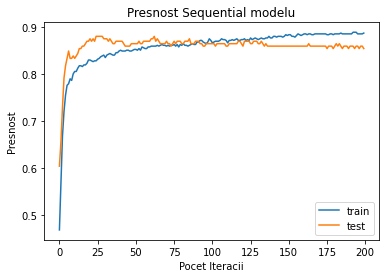

In [19]:
#graf pre Presnost Sequential modelu
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Presnost Sequential modelu')
plt.ylabel('Presnost')
plt.xlabel('Pocet Iteracii')
plt.legend(['train', 'test'])
plt.show()

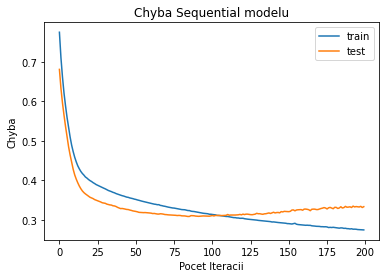

In [20]:
#graf pre Chybu Sequential modelu
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Chyba Sequential modelu')
plt.ylabel('Chyba')
plt.xlabel('Pocet Iteracii')
plt.legend(['train', 'test'])
plt.show()

In [21]:
#vypis finalnej presnosti Sequential modelu
scores = model_sequential.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (model_sequential.metrics_names[1], scores[1]*100))

accuracy: 85.42%


In [22]:
#tu som skusal Random Forest algoritmus, chcel som vidiet aku bude mat presnost kedze sa implementovalo jednoducho a casto sa pouziva 
random_forest_model=RandomForestClassifier(random_state=1)
random_forest_model.fit(X_train, y_train.ravel())
predict_train_data=random_forest_model.predict(X_test)
print("Accuracy = {0:.3f}".format(metrics.accuracy_score(y_test, predict_train_data)))

Accuracy = 0.891


In [23]:
#Zadal som udaje pri ktorych ocakavam ze predikcia bude ze ma cukrovku
#=Cukrovka
testing_values_1=np.array([('8','183.0','64.0','33.0','206.846154','23.3','0.672','32')])
#Zadal som udaje pri ktorych ocakavam ze predikcia bude ze je zdravy
#=Zdravý
testing_values_2=np.array([('1','93.0','70.0','31.0','130.287879','30.4','0.315','23')])

In [24]:
testing_values_1
testing_values_2

array([['1', '93.0', '70.0', '31.0', '130.287879', '30.4', '0.315', '23']],
      dtype='<U10')

In [25]:
#Standardizacia novych udajov
testing_values_1=sc.transform(testing_values_1)
testing_values_2=sc.transform(testing_values_2)

In [26]:
#ulozenie predikcii pomocou modelu Sequential
predictions_sequential=[]
predictions_sequential.append(model_sequential.predict(testing_values_1))
predictions_sequential.append(model_sequential.predict(testing_values_2))

In [27]:
predictions_sequential

[array([[0.95684075]], dtype=float32), array([[0.02456653]], dtype=float32)]

In [28]:
#Vypis predikcii, vypisuje presnost v %, ak predikcia mala hadnotu <0.5 tak by nemal mat cukrovku a ak >=0.5 tak 
#by mal mat cukrovku na X%
for index,x in enumerate(predictions_sequential):
    index+=1
    if x>=0.5:
        print("Záznam:",index,"- Na ",x*100," percent že má cukrovku")
    if x<0.5:
        print("Záznam:",index,"- Na ",100-x*100," percent že je zdravý")

Záznam: 1 - Na  [[95.684074]]  percent že má cukrovku
Záznam: 2 - Na  [[97.54335]]  percent že je zdravý


In [29]:
#To iste som spravil aj pre algoritmus Random Forest ak som to uz skusal
#Tu dostavame len hodnotu 0 alebo 1 

In [30]:
predictions_forest=[]
predictions_forest.append(random_forest_model.predict(testing_values_1))
predictions_forest.append(random_forest_model.predict(testing_values_2))

In [31]:
for index,x in enumerate(predictions_forest):
    index+=1
    if x==0:
        print("Záznam:",index,"- Zdravý")
    else:
        print("Záznam:",index,"- Cukrovka")

Záznam: 1 - Cukrovka
Záznam: 2 - Zdravý
